# Distribución óptima de dispositivos de feromonas en plantaciones

El objetivo es implementar un algoritmo para optimizar la distribución de dispositivos en una plantación, de manera que se se minimice la cantidad de dispositivos sujeto a una restricción, y que éstos se distribuyan de manera uniforme en la plantación.

- El problema corresponde en definir _hileras_ de dispositivos en una hectárea con $p$ plantas, de manera que se minimice la cantidad de dispositivos instalados $d$, sujeto a una restricción de densidad mínima por hectárea $d_{\min} \in \{50, 200, 300, 500\}$. Notar que no necesariamente se cumple que $p \geq d_{\min}$.
- Se requiere que los dispositivos estén distribuidos de manera uniforme en la hectárea. Sin embargo, no se requiere que la distribución sea estrictamente regular, y se prefieren patrones "simples" (ver abajo).

Complementario a las definiciones estrictas del problema, se definen las siguientes restricciones operacionales para la implementación práctica de una solución.

- Se requiere que los patrones de instalación de dispositivos definidos para cada hilera sean "simples". La operacionalización de esta restricción se explica en la siguiente sección.
- Es preferible minimizar la cantidad $n$ de hileras definidas. Esto es, se prefiere una solución con pocas hileras, que una con muchas hileras.
- En términos operacionales, se requiere que la cantidad $d$ de dispositivos instalados no supere la densidad mínima más allá de un margen definido. Operacionalizamos esta restricción definiendo una ventana para las soluciones admisibles de la forma $d_{\min} \leq d \leq d_{\min}\cdot \delta$, donde $\delta \geq 1$ es un factor de tolerancia.

## 1. Exploración del problema

El problema de optimización tiene una solución trivial si 
- no se requiere uniformidad en la distribución de los dispositivos, y
- asumimos que $p \geq d_{\min}$.

En esta versión simple del problema, este corresponde a $\min_{d} d$ sujeto a $d_{\min} \leq d$, por lo que es evidente que $d^* = d_{\min}$. Es decir, sin importar $p$, deben instalarse $d^* = d_{\min}$ dispositivos. Dado el supuesto que $p \geq d_{\min}$, esto siempre será posible (porque $d \leq p$ por construcción).


### _Ratio_ de una solución

Introducimos ahora el concepto de **ratio** entre dispositivos y plantas, el que será útil para todo el análisis.
Definimos el ratio $r$ como la densidad relativa de dispositivos en una plantación con $p$ plantas, es decir,
$$r \equiv \frac{d}{p}.$$
Notar que $r \in (0,1]$.
Adicionalmente, definimos el **ratio mínimo** como $r_{\min} \equiv d_{\min}/p$.
Por ejemplo, una plantación con $(p=15, d_{\min}=6)$ tiene un ratio mínimo de $r_{\min} = 0.4$.
En general, para una solución $j$ que induce una densidad $d_j$, el ratio correspondiente es $r_j = d_j/p$.


### Solución en espacio discreto

Consideramos ahora que el problema requiere que los dispositivos se distribuyan de manera uniforme en la plantación con un número discreto $p$ de plantas.
Una distribución perfectamente uniforme en dicho espacio es imposible, pero puede aproximarse razonablemente bien con un método simple.
Intuitivamente, un patrón de instalación que considere un dispositivo cada $1/r_{\min}$ plantas coincidirá con el ratio mínimo.
Por ejemplo, si $r_{\min} = 0.4$, entonces debe instalarse un dispositivo cada $2.5$ plantas.
El código a continuación muestra cómo podemos crear un patrón de instalación usando esta lógica:

In [24]:
import math

def gen_solution_simple(p, d_min):
    r = d_min/p
    cumsum = [math.ceil(i*r) for i in range(1, p+1)]
    pattern = [cumsum[i] - cumsum[i-1] if i > 0 else cumsum[i] for i in range(len(cumsum))]
    return {'patron': pattern, 'densidad': sum(pattern)}

p = 15
d_min = 6
gen_solution_simple(p, d_min)

{'patron': [1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0], 'densidad': 6}

Otra manera de expresar el mismo concepto es considerar que $r_{\min} = 0.4 = 2/5$, lo que interpretamos como una instrucción para instalar 2 dispositivos cada 5 plantas.
Esto permite generalizar intuitivamente la interpretación para casos donde $d_{\min} > p \iff r_{\min} > 1$.
Por ejemplo, si $r_{min} = 1.\bar{6} = 5/3$, entonces debe instalarse 5 dispositivos cada 3 plantas.

In [25]:
p = 15
d_min = 25
gen_solution_simple(p, d_min)

{'patron': [2, 2, 1, 2, 2, 1, 2, 2, 1, 2, 2, 1, 2, 2, 1], 'densidad': 25}

### Solución con patrón de instalación "simple"

Una solución generada con el método descrito anteriormente logra la densidad mínima y distribuye los dispositivos de manera lo más uniforme posible en un espacio discreto.
Sin embargo, presenta el problema de que potencialmente contiene dos patrones de instalación, dado el error de redondeo que se produce en el espacio discreto.
En el ejemplo con $r_{min} = 0.4$, tenemos que el patrón alterna las secuencias `[1, 0]` y `[1, 0, 0]`.
Esto indica que debe instalarse 1 dispositivo cada 2 plantas y luego 1 dispositivo cada 3 plantas, de forma que se alternan dos patrones de instalación.
En general, con este método podemos obtener soluciones que alternan hasta dos patrones (`[1, 0]` y `[1, 0, 0]`), y posiblemente alternan dichos patrones de manera irregular (por ejemplo, `[1, 0, 0]`, `[1, 0, 0]`, `[1, 0]`).

La solución del problema requiere encontrar una conjunto de **hileras simples**, esto es, que cada una defina un único patrón de instalación.
Esta última restricción motiva la solución al problema presentada a continuación.

## 2. Algoritmo de solución óptima


### Caracterización de una solución

Una **solución** del problema es un vector $R \in P^n$, de forma que $R = (r_1, \ldots, r_n)$, donde $n$ representa la cantidad de hileras definidas.
Cada elemento $r_i \in P$ es una fracción que representa el **ratio** de la hilera $i$, que indica el número de dispositivos sobre el total de plantas.
Por ejemplo, si $r_i = 2/3$ entonces esto indica que en la hilera $i$ deben instalarse 2 dispositivos cada 3 plantas, y si $r_i = 1/4$ entonces deben instalarse 1 dispositivo cada 4 plantas, etc.

El conjunto $P$ de posibles ratios es

$$ P = \left\{ 1, \frac{4}{5}, \frac{2}{3}, \frac{3}{5}, \frac{1}{2}, \frac{1}{3}, \frac{1}{4}, \frac{1}{5} \right\} $$

La definición de los valores en $P$ está motivada por la necesidad de que los patrones de instalación sean "simples". 

De esta forma, una solución $R$ define una distribución de dispositivos en la plantación. Por ejemplo, si $R = (2/3, 1/4)$ entonces esto indica que se debe instalar 2 dispositivios cada 3 plantas en la primera hilera, y luego 1 dispositivo cada 4 plantas en la segunda hilera. Este patrón se repite hasta completar la plantación.

### Planteamiento del problema y estrategia de solución

El problema de optimización a resolver es
$$
\min_{n, R} d(R; p) \quad \text{sujeto a} \quad d \geq d_{\min}.
$$
Resolver un problema así presenta tres importantes dificultades.
1. Dado que $r_i \in P$, esto implica un problema de optimización lineal discreto, ya que los valores de la variables de decisión en $R$ están restringidos a un conjunto discreto finito.
2. La función objetivo $d(R; p)$ no es lineal (ver abajo), de forma que el problema de optimización es no-lineal.
2. El problema de optimización es sobre $n$ y $R$, de forma que estamos optimizando sobre la cantidad de variables de decisión del problema. Esto transforma el problema en uno de optimización de largo variable.

Dadas estas dificultades para encontrar una solución analítica, se propone un algoritmo de solución de fuerza bruta, lo que además es factible dado que el espacio de soluciones es relativamente pequeño.
Intuitivamente, el algoritmo de solución consiste en evaluar todas las posibles soluciones dado $P$ y fijando un número máximo de hileras $n = n_{\max}$.
Analizamos el espacio de soluciones a continuación.

### Espacio de soluciones

Dado un número de hileras $n$, podemos generar todas las combinaciones de largo $n$ de elementos de $P$, es decir, todas las posibles soluciones de $n$ hileras.
El número de estas soluciones es
$$
\frac{(\#P+n-1)!}{n!(\#P-1)!}
$$

Fijando un número máximo de hileras $n_{\max}$, podemos generar todas las posibles soluciones de $1$ a $n_{\max}$ hileras.
El número total de de soluciones en este conjunto es
$$
k = \sum_{n=1}^{n_{\max}}\frac{(\#P+n-1)!}{n!(\#P-1)!}
$$

Entonces, el **espacio de soluciones** $\mathcal{R} = \{ R_1, \ldots, R_k \}$ es el conjunto de todas las posibles soluciones de $1$ a $n_{\max}$ hileras, dado $P$ y $n_{\max}$. En Python, generamos el espacio de soluciones con el siguiente código.

```python
def gen_solution_space(P, n_max):
    """Generate solution space with all possible combinations of patterns.
    This function is completely independent of the problem, and just depends on two user-defined parameters: 
    `n_max` (maximum number of patterns) and `P` (list of possible patterns)."""                
    def generate_combinations(elements, n):
        combinations = []
        for r in range(1, n+1):
            combinations.extend(combinations_with_replacement(elements, r))
        return combinations
    
    all_R = generate_combinations(P, n_max)
    return all_R
```


En particular, para $\#P=8$ (como definimos arriba) y fijando $n_{\max}=4$ hileras, el espacio de soluciones tiene 494 soluciones. Este hecho es uno de los que motiva el uso de un algoritmo de optimización de fuerza bruta para encontrar soluciones óptimas.

In [2]:
### Compute cardinality of solution space

import math
# Define the values for #R and n_max
n_max = 4  # For example
len_R = 8  # For example
# Calculate the sum
s = 0
for n in range(1, n_max + 1):
    s += math.factorial(len_R + n - 1) / (math.factorial(n) * math.factorial(len_R - 1))

print(s)

494.0



### Evaluación de una solución

Habiendo definido un espacio de soluciones, nos interesa ahora definir un criterio para evaluar una solución $R_j \in \mathcal{R}$.
Dada la naturaleza del problema, son de interés dos variables:
1. la cantidad $n$ de hileras utilizadas, y
2. la cantidad $d$ de dispositivos instalados.

Nos interesa minimizar $n$ porque un menor número de hileras implica un conjunto de instrucciones más simple para llevar a cabo la instalación de dispositivos. Calcular $n_j$ para un $R_j$ dado es trivial.

En segundo lugar, nos interesa también minimizar $d$ porque un menor número de dispositivos implica un menor costo de instalación. Sin embargo, el problema requiere respetar una densidad mínima $d_{\min}$, de forma que $d \geq d_{\min}$.
Dada una solución $R_j$, la cantidad $d_j(R_j; p)$ de dispositivos instalados puede aproximarse como

$$
d(R; p) \approx \sum_{i=1}^n \left\lceil r_i \cdot \frac{p}{n} \right\rceil
$$

En Python implementamos la siguiente función para calcular $d$.
La diferencia es que la implementación en código considera el hecho de que $r_i \cdot p/n \notin \mathbb{Z}$, es decir, que el patrón de instalación puede no coincidir exactamente con el largo de la hilera.

```python
def compute_real_density(R, p):
    """Compute the real density of a solution vector R.

    Args:
        R (tuple): Solution vector.
        p (int): Number of plants.

    Returns:
        d (int): Number of installed devices.
    """            
    n = len(R)
    n_ = np.floor(p/n)  # still haven't thought through what to do if this is not an integer
    R_frac = [Fraction(f).limit_denominator() for f in R]
    d_full_pattern = [np.floor((n_)/f.as_integer_ratio()[1])*f.as_integer_ratio()[0] for f in R_frac]
    d_partial_pattern = [min(np.mod(n_, f[1]), f[0]) for f in [f.as_integer_ratio() for f in R_frac]]
    return int(np.sum(d_full_pattern) + np.sum(d_partial_pattern))
```

### Optimalidad de una solución

Al evaluar la solución $R_j$, obtenemos un par $(n_j, d_j)$ que la caracteriza, donde $n_j$ es el número de hileras y $d_j$ es la densidad de la solución $R_j$.
El algoritmo de búsqueda de óptimo se reduce a evaluar todas las soluciones $R_j \in \mathcal{R}$ y seleccionar la solución óptima bajo algún criterio que combine $n_j$ y $d_j$.
En particular, se reportan dos soluciones:
1. la solución óptima $R^{\dagger}$ que minimiza $n$ y luego $d$, y
2. la solución óptima $R^*$ que minimiza $d$ y luego $n$.

## 3. Implementación

La clase `chalicelib.devices.Pattern` implementa los métodos descritos hasta ahora.
Abajo se muestra un ejemplo de uso para resolver un problema particular donde $p=444$ y $d_{\min}=200$.

In [3]:
from chalicelib.devices import Pattern

pattern = Pattern(p=444, d_min=200, n_max=4, tolerance_factor=1.1)
pattern.find_optimal_solutions(fractions=True)

((204, ['2/3', '1/4']), (200, ['4/5', '1/3', '1/3', '1/3']))

Podemos evaluar sistemáticamente las soluciones encontradas por el algoritmo, para verificar que encuentra soluciones razonables para cualquier combinación de $p$ y $d_{\min} \in \{200, 300, 500\}$.

El código para generar soluciones para distintos valores de $d_{\min}$ a lo largo de un rango razonable de valores de $p$ se encuentra a continuación.
De los gráficos resultantes, notamos que el algoritmo encuentra soluciones satisfactorias para cualquier combinación de $p$ y $d_{\min}$.
- Al minimizar densidad, notamos que siempre cumplimos el objetivo de densidad mínima, y ninguna solución supera la mínima por más de 4%. Esto se logra fijando un número máximo de 4 hileras.
- Al minimizar el número de hileras, vemos que más del 95% de las soluciones usa 2 o 1 hilera. Esto se logra fijando una densidad máxima de 10% sobre la densidad mínima.

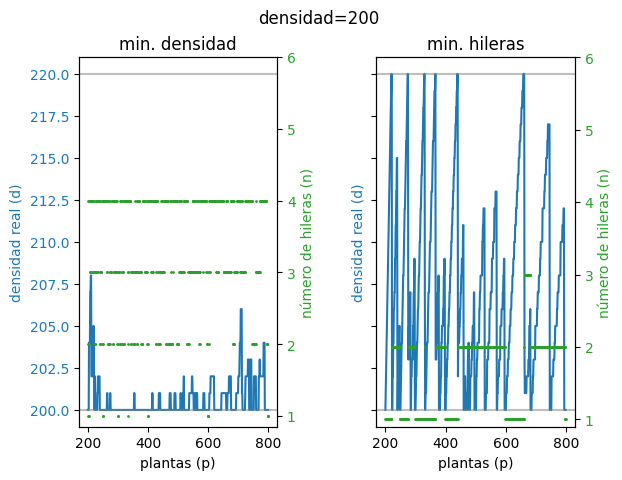

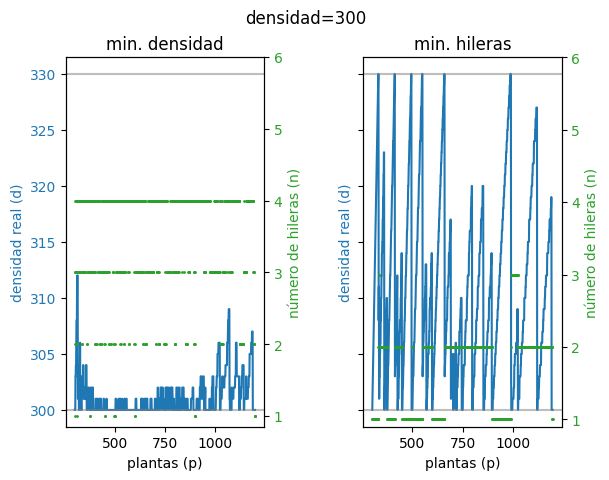

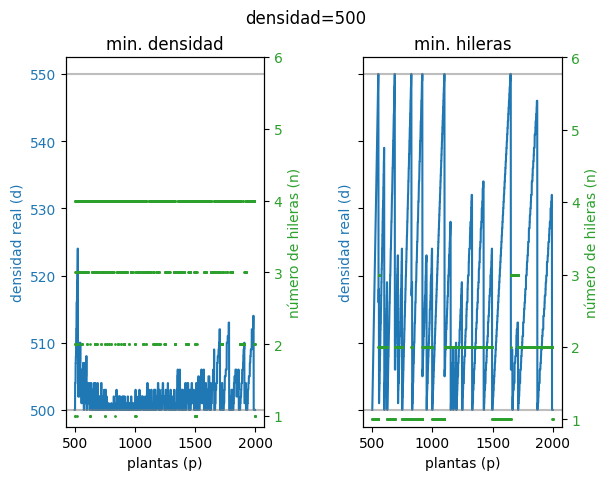

In [4]:
from chalicelib.plots import gen_eval_plot, gen_solutions_linrange
import matplotlib.pyplot as plt

for d_min in [200, 300, 500]:
    X_min_n, X_min_d, P = gen_solutions_linrange(d_min, 4, 1.1, d_min*4)
    fig, axs = plt.subplots(1, 2, sharey=True)
    fig.suptitle(f'densidad={d_min}')


    axs[0] = gen_eval_plot(axs[0], P, X_min_d[0], X_min_d[1], d_min, 'min. densidad')
    axs[1] = gen_eval_plot(axs[1], P, X_min_n[0], X_min_n[1], d_min, 'min. hileras')
    plt.subplots_adjust(wspace=.5)